# Example: load processed run data, perform azimuthal integration and plot
Note: When loading data from the same hdf5 file (with changed contents), you may have to restart the kernel to avoid getting a cached version of the old data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import xarray as xr
import os
from tqdm.auto import tqdm
from os.path import join
from time import strftime
from scipy.stats import linregress

from karabo_data.geometry2 import DSSC_1MGeometry

In [16]:
%matplotlib inline

In [3]:
def merge_images(image1, image2, keys=None):
    '''Merge two processed run images by calculating the weighted sum
    of data variables. Requires sum_count variable to calculate the new average.
    '''
    if keys is None:
        keys = ['pumped', 'unpumped', 'xgm_pumped', 'xgm_unpumped']
    run1 = image1.run.values
    run2 = image2.run.values
    image1 = image1.drop('run')
    image2 = image2.drop('run')
    
    for k in keys:
        image2[k] = image2[k] * image2.sum_count
        image1[k] = image1[k] * image1.sum_count

    merged = xr.concat([image1, image2], dim='image')
    merged = merged.sum('image')

    for k in keys:
        merged[k] = merged[k] / merged.sum_count
    merged['run'] = np.append(run1, run2)
    return merged


def load_geom(dx=0, dy=0):
    '''Load DSSC geometry with quick-and-dirty center adjustment'''
    quad_pos = [
        (-124.100 + dx,    3.112 + dy),  # TR
        (-133.068 + dx, -110.604 + dy),  # BR
        (   0.988 + dx, -125.236 + dy),  # BL
        (   4.528 + dx,   -4.912 + dy)   # TL
        ]
    path = '/gpfs/exfel/sw/software/exfel_environments/misc/git/karabo_data/docs/dssc_geo_june19.h5'
    geom = DSSC_1MGeometry.from_h5_file_and_quad_positions(path, quad_pos)
    return geom


def quickmask_DSSC_ASIC(geom, poslist):
    '''
    Returns a mask for the given DSSC geometry with ASICs given in poslist blanked.
    poslist is a list of (module, row, column) tuples. Each module consists of 2 rows and
    8 columns of individual ASICS.
    '''
    mask = np.ones([16, 128, 512], dtype=float)  # need floats to use NaN
    for (module, row, col) in poslist:
        mask[module, 64 * row:64 * (row + 1), 64 * col:64 * (col + 1)] = np.nan
    return geom.position_modules_fast(mask)[0]


class azimuthal_integrator(object):
    def __init__(self, imageshape, center, polar_range, dr=2, rmin=0):
        '''
        Create a reusable integrator for repeated azimuthal integration of similar
        images. Calculates array indices for a given parameter set that allows
        fast recalculation.
        
        Parameters
        ==========
        imageshape : tuple of ints
            The shape of the images to be integrated over.
            
        center : tuple of ints
            center coordinates in pixels
        
        polar_range : tuple of ints
            start and stop polar angle (in degrees) to restrict integration to wedges
        
        dr : int, default 2
            radial width of the integration slices. Takes non-square DSSC pixels into account.
            
        rmin : int
            
        
        Returns
        =======
        ai : azimuthal_integrator instance
            Instance can directly be called with image data:
            > az_intensity = ai(image)
            radial distances and the polar mask are accessible as attributes:
            > ai.distance
            > ai.polar_mask
        '''
        self.shape = imageshape
        self.dr = dr
        cx, cy = center
        sx, sy = imageshape
        xcoord, ycoord = np.ogrid[:sx, :sy]
        xcoord -= cx
        ycoord -= cy

        # distance from center, hexagonal pixel shape taken into account
        dist_array = np.hypot(xcoord * 204 / 236, ycoord)

        # array of polar angles
        tmin, tmax = np.deg2rad(np.sort(polar_range)) % np.pi
        polar_array = np.arctan2(xcoord, ycoord)
        polar_array = np.mod(polar_array, np.pi)
        self.polar_mask = (polar_array > tmin) * (polar_array < tmax) * (dist_array > rmin)

        self.maxdist = min(sx  - cx, sy  - cy)
        self.mindist = max(rmin, dr)

        ix, iy = np.indices(dimensions=(sx, sy))
        self.index_array = np.ravel_multi_index((ix, iy), (sx, sy))

        self.distance = np.array([])
        self.flat_indices = []
        for dist in range(self.mindist, self.maxdist, dr):
            ring_mask = self.polar_mask * (dist_array >= (dist - dr)) * (dist_array < dist)
            self.flat_indices.append(self.index_array[ring_mask])
            self.distance = np.append(self.distance, dist)
    
    def __call__(self, image):
        assert self.shape == image.shape, 'image shape does not match'
        image_flat = image.flatten()
        return np.array([np.nansum(image_flat[indices]) for indices in self.flat_indices])

## optional: load binary DSSC mask

In [140]:
# from imageio import imread
# dssc_mask = imread('./DSSC_mask_1.bmp')[..., 0]
# dssc_mask = dssc_mask.astype(float) // 255
# dssc_mask[dssc_mask==0] = np.nan

# dssc_mask = 1

## load DSSC geometry

In [4]:
geom = load_geom(dx=1.3)

## optional: generate mask for individual ASICs

In [5]:
masklist = [
    (1, 0, 6),  # permanent?
    (9, 0, 6),  # permanent?
    (4, 1, 0),  # permanent?
    (15, 0, 4),
    (15, 1, 4),
    (11, 0, 6),
]
dssc_mask = quickmask_DSSC_ASIC(geom, masklist)

# load aggregated run data

In [30]:
darkrun_nr = 53
run_nr = 62

In [31]:
datadir = 'processed_runs'
prefix = '191017_01_'

dark = xr.open_dataset(join(datadir, f'{prefix}run{darkrun_nr}.h5'), group='data', autoclose=True)
data = xr.open_dataset(join(datadir, f'{prefix}run{run_nr}_by-pulse.h5'), group='data', autoclose=True)

In [32]:
image = (data['image'] - dark['image']).to_dataset(name='image')
image['xgm'] = data.xgm
image['run'] = data.run
image['sum_count'] = data.sum_count

# normalize by XGM

In [33]:
im_norm = (image.image) / image.xgm

# get a single averaged image to align the azimuthal integration

In [34]:
im_mean, center = geom.position_modules_fast(im_norm.mean('pulse'))

In [44]:
# angle_range = [118, 165]
angle_range = [15, 72]
ai = azimuthal_integrator(im_mean.shape, center, angle_range, dr=2, rmin=50)
norm = ai(~np.isnan(im_mean * dssc_mask))

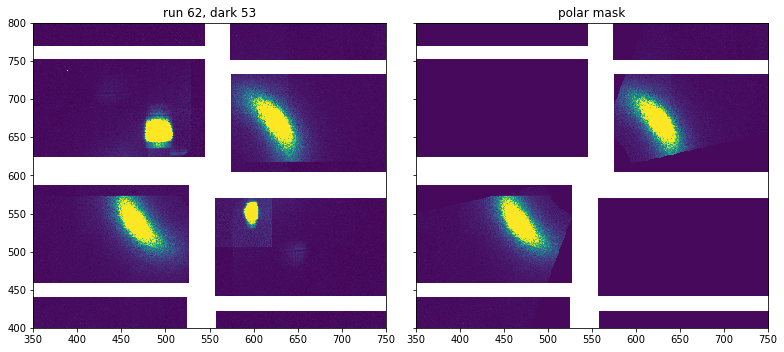

In [47]:
fig, [ax1, ax2] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[11, 6])

vmin, vmax = np.percentile(im_mean[~np.isnan(im_mean)], [2, 99.6])
ax1.imshow(dssc_mask * im_mean, vmin=vmin, vmax=vmax, aspect=204/236)
ax2.imshow(dssc_mask * im_mean * ai.polar_mask, vmin=vmin, vmax=vmax, aspect=204/236)

runstr = '+'.join([str(i) for i in [image.run.values]])
ax1.set_title(f'run {runstr}, dark {darkrun_nr}')
ax2.set_title('polar mask')

ax1.set_ylim(400, 800)
ax1.set_xlim(350, 750)

plt.tight_layout()

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{runstr}_mean_{tstamp}.png', dpi=300)

## optional: save a bitmap to draw a new mask

In [170]:
from imageio import imsave
im_mean_bmp = np.nan_to_num(np.clip(im_mean, vmin, vmax))
im_mean_bmp /= im_mean_bmp.max()
imsave('dssc_mean.bmp', 255 * im_mean_bmp)

# azimuthal integration for each delay

In [48]:
az_int = []

im_arranged = geom.position_modules_fast(im_norm.values)[0]

for i in tqdm(range(len(im_norm.pulse))):
    az_int.append(ai(dssc_mask * im_arranged[i]) / norm)

az_int = np.stack(az_int)

# momentum transfer

In [49]:
coords = {'pulse': im_norm.pulse.values, 'distance': ai.distance}
azimuthal = xr.DataArray(az_int, dims=['pulse', 'distance'], coords=coords)
azimuthal = azimuthal.to_dataset(name='intensity')
azimuthal = azimuthal.transpose('distance', 'pulse')

wl = 1.59e-9
detector_distance = 430e-3
azimuthal['delta_q'] = 2e-9 * np.pi * np.sin(np.arctan(azimuthal.distance * 204e-6 / detector_distance)) / wl

azimuthal = azimuthal.swap_dims({'distance': 'delta_q'})

# plot 2d magnetization and linescans

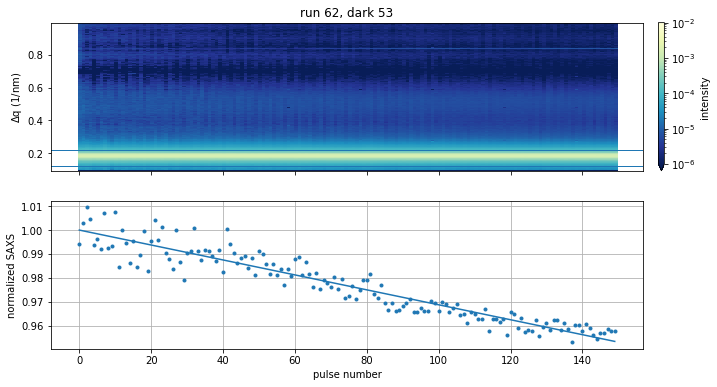

In [52]:
# qranges = np.linspace(80, 480, 8)
qranges = [0.12]#, .15, .2, .25]
qwidth = 4 * [.1]

fig = plt.figure(figsize=[11, 6])
grid = GridSpec(2, 2, figure=fig, width_ratios=[1, .01], wspace=.05)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0], sharex=ax1)
cax = fig.add_subplot(grid[0, 1])

lognorm = LogNorm(1e-6, 1e-2)
cmap = plt.get_cmap('YlGnBu_r')
cmap.set_bad(cmap(0))
xr.plot.imshow(azimuthal.intensity, ax=ax1, add_colorbar=True, cbar_ax=cax, norm=lognorm, cmap=cmap)

runstr = '+'.join([str(i) for i in [image.run.values]])

ax1.set_title(f'run {runstr}, dark {darkrun_nr}')
ax1.set_ylabel('$\Delta$q (1/nm)')
ax1.set_xlabel('')

for i, q0 in enumerate(qranges):
    w = qwidth[i]
    sel = (azimuthal.delta_q > q0) * (azimuthal.delta_q < (q0 + w))
    val = (azimuthal.intensity).where(sel).mean('delta_q')
    reg = linregress(x=azimuthal.pulse, y=val)
    fit = (reg.intercept + azimuthal.pulse * reg.slope) / reg.intercept
    ax2.plot(azimuthal.pulse, val / reg.intercept, 'o', ms=3, c=f'C{i}')
    ax2.plot(azimuthal.pulse, fit, c=f'C{i}')
    ax1.axhline(q0, c=f'C{i}', lw=1)
    ax1.axhline(q0 + w, c=f'C{i}', lw=1)

plt.setp(ax1.get_xticklabels(), visible=False)
ax2.set_xlabel('pulse number')
ax2.set_ylabel('normalized SAXS')
ax2.grid(True)

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{runstr}_2d-map_{tstamp}.png', dpi=300)

# plot azimuthal intensity for different pulses

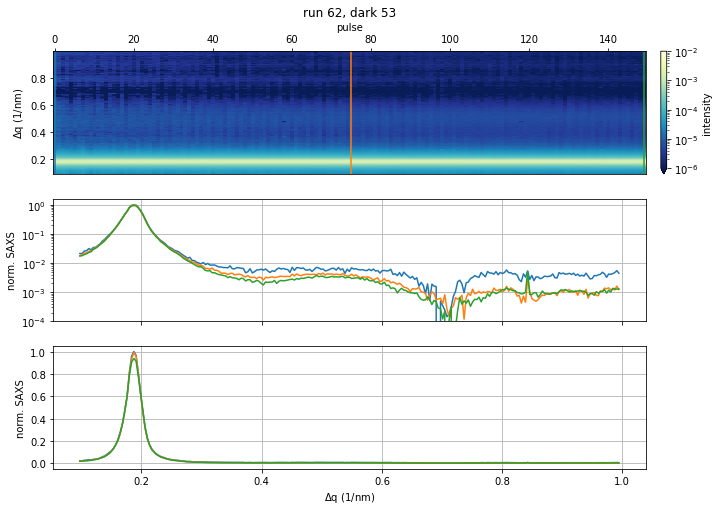

In [54]:
fig = plt.figure(figsize=[11, 8])
# widget backend doesn't respect figsize yet
# fig.canvas.layout.height = '6in'
# fig.canvas.layout.width = '9in'

grid = GridSpec(3, 2, figure=fig, width_ratios=[1, .01], wspace=.05, hspace=.2,
                top=.85)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0], sharex=ax2)
cax = fig.add_subplot(grid[0, 1])

lognorm = LogNorm(1e-6, 1e-2)
cmap = plt.get_cmap('YlGnBu_r')
cmap.set_bad(cmap(0))
xr.plot.imshow(azimuthal.intensity, ax=ax1, add_colorbar=True, cbar_ax=cax, norm=lognorm, cmap=cmap)

pulses = [0, len(azimuthal.pulse) // 2, len(azimuthal.pulse) - 1]
for i, pulse in enumerate(pulses):
    ax1.axvline(pulse, c=f'C{i}')
    sel = azimuthal.loc[{'pulse': pulse}]
    if i == 0:
        norm = sel.intensity.max()
    for ax in [ax2, ax3]:
        ax.plot(sel.delta_q, sel.intensity / norm)
        ax.grid(True)
        ax.set_ylabel('norm. SAXS')

ax1.set_title(f'run {runstr}, dark {darkrun_nr}')
ax1.set_ylabel('$\Delta$q (1/nm)')
ax1.set_xlabel('pulse')
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')

ax2.set_yscale('log')
ax2.set_ylim(1e-4)
plt.setp(ax2.get_xticklabels(), visible=False)

ax3.set_xlabel('$\Delta$q (1/nm)')

tstamp = strftime('%y%m%d_%H%M')
# fig.savefig(f'images/run{runstr}_2d-map_az_{tstamp}.png', dpi=300)